# Practica-15: Representación de volumen (parte 2)

**Objetivo**: Crear representaciones de volumen para visualizar cubos de datos de simulación 3D. Esta técnica es útil cuando tiene datos que llenan el espacio que le gustaría visualizar. Dichos datos aparecen a menudo en conjuntos de *datos astrofísicos*, pero también en otras áreas de *gráficos por computadora* y *datos médicos* (tomografía computarizada, TAC y resonancia magnética nuclear, IMR).

## Ejemplo: Cubo de datos

Suponemos que los datos son un cubo de datos $Nx \times Ny \times Nz$ de una densidad que nos gustaría visualizar.


## Función de transferencia

Primero, definiremos una función de transferencia personalizada que devolverá un valor de *rojo, verde, azul* y *opacidad* $(r,g,b,a)$ en función de la densidad de entrada. 

- Esta función realmente puede ser cualquier elección que desee, pero una buena estrategia es elegir ciertos valores de densidad que le interesen más visualizar y hacer que la función de transferencia sea opaca ($a\sim 1$) alrededor de esos valores, y tener un color específico en ese valor. 

- El algoritmo de representación de volumen, en cierto sentido, crea un gráfico de iso-contorno 3D. 


A continuación, codificamos un ejemplo de función de transferencia que selecciona ciertos valores de densidad colocando gaussianas estrechas en $x=9$, $x=3$ y $x=-3$. Cada gaussiana tiene su propia opacidad máxima $a$ y colores $r,g,b$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
from scipy.interpolate import interpn

In [2]:
# Simular el sistema de Schrödinger-Poisson con el método espectral

def transferFunction(x):
    # La función de transferencia devuelve los valores r,g,b,a en función de la densidad x
    
    r = 1.0*np.exp( -(x - 9.0)**2/1.0 ) +  0.1*np.exp( -(x - 3.0)**2/0.1 ) +  0.1*np.exp( -(x - -3.0)**2/0.5 )
    g = 1.0*np.exp( -(x - 9.0)**2/1.0 ) +  1.0*np.exp( -(x - 3.0)**2/0.1 ) +  0.1*np.exp( -(x - -3.0)**2/0.5 )
    b = 0.1*np.exp( -(x - 9.0)**2/1.0 ) +  0.1*np.exp( -(x - 3.0)**2/0.1 ) +  1.0*np.exp( -(x - -3.0)**2/0.5 )
    a = 0.6*np.exp( -(x - 9.0)**2/1.0 ) +  0.1*np.exp( -(x - 3.0)**2/0.1 ) + 0.01*np.exp( -(x - -3.0)**2/0.5 )

    return r,g,b,a

## Representación de volumen

- Suponga que conoce los valores de densidad en un cubo de datos que llamaremos la *cuadrícula de la cámara*. 
- Luego deseamos crear una imagen $R,G,B$ del renderizado. 
- Inicializamos cada canal de color a 0. 
- Cada píxel de la imagen representa un rayo que se proyecta desde la parte posterior del volumen hacia el frente, que pasará a través del campo de densidad y alterará su color hasta llegar al frente, produciendo la imagen final. 
- En cada paso, la función de transferencia devuelve valores $r,b,g,a$, y la imagen se actualiza como: 

$$R=a \times r + (1-a) \times R$$
$$G=a \times r + (1-a) \times G$$
$$B=a \times r + (1-a) \times B$$

## Interpolación de Datacube en la cuadrícula de la cámara

Es posible que deseemos visualizar el cubo de datos original tal como está, en cuyo caso podemos igualar estas cosas (camera_grid = datacube). Pero también es posible que deseemos rotar la vista de la cámara del renderizado, lo que puede ayudarnos a visualizar mejor el conjunto de datos y seleccionar más fácilmente la estructura 3D. 

- En este caso, es necesario interpolar el cubo de datos original en la cuadrícula de la cámara que está alineada con el ángulo en el que le gustaría ver el conjunto de datos. 

Al ejecutar el siguiente código permite crear una representación de volumen de un cubo de datos de simulación y compararlo con una proyección simple (*para aquellos interesados, el cubo de datos es de una simulación de sistema cuántico*). 
- Observe cómo la representación del volumen selecciona más estructura que se desvanece en la proyección:

Rendering Scene 1 of 10.

Rendering Scene 2 of 10.

Rendering Scene 3 of 10.

Rendering Scene 4 of 10.

Rendering Scene 5 of 10.

Rendering Scene 6 of 10.

Rendering Scene 7 of 10.

Rendering Scene 8 of 10.

Rendering Scene 9 of 10.

Rendering Scene 10 of 10.



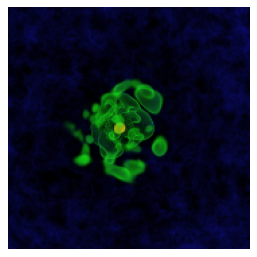

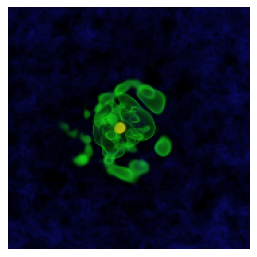

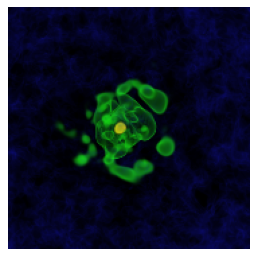

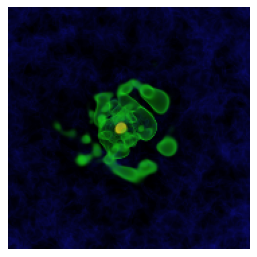

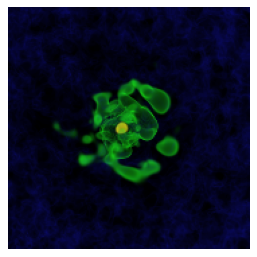

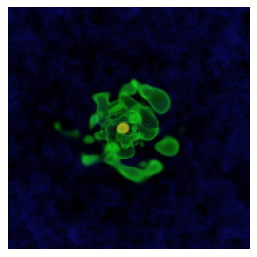

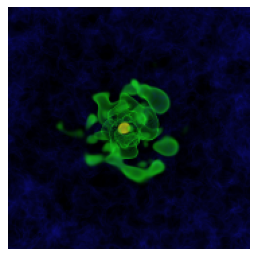

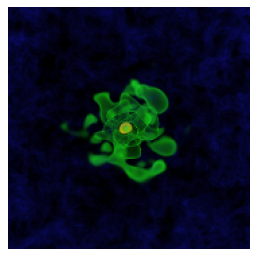

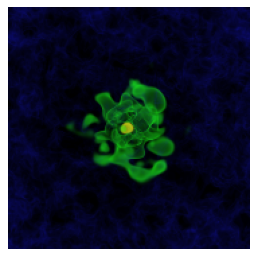

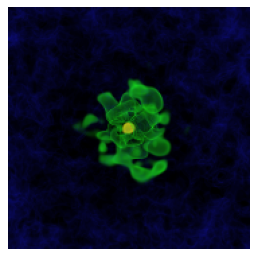

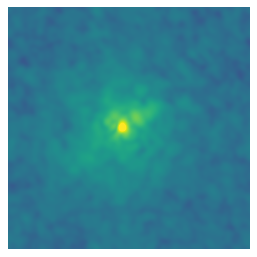

In [3]:
def main():
    
    # Representación de volumen

    # Cargar el cubo de datos original
    f = h5.File('datacube.hdf5', 'r')
    datacube = np.array(f['density'])

    # Construya las coordenadas de cuadrícula del cubo de datos correspondiente
    Nx, Ny, Nz = datacube.shape
    x = np.linspace(-Nx/2, Nx/2, Nx)
    y = np.linspace(-Ny/2, Ny/2, Ny)
    z = np.linspace(-Nz/2, Nz/2, Nz)
    points = (x, y, z)

    # Realice la representación de volumen en diferentes ángulos de visión
    Nangles = 10
    for i in range(Nangles):

        print('Rendering Scene ' + str(i+1) + ' of ' + str(Nangles) + '.\n')

        # Construya la cuadrícula de la cámara/los puntos de consulta: gire la vista de la cámara
        angle = np.pi/2 * i / Nangles
        N = 180
        c = np.linspace(-N/2, N/2, N)
        qx, qy, qz = np.meshgrid(c,c,c)
        qxR = qx
        qyR = qy * np.cos(angle) - qz * np.sin(angle) 
        qzR = qy * np.sin(angle) + qz * np.cos(angle)
        qi = np.array([qxR.ravel(), qyR.ravel(), qzR.ravel()]).T

        # Interpolar en la cuadrícula de la cámara
        camera_grid = interpn(points, datacube, qi, method='linear').reshape((N,N,N))

        # Hacer renderizado de volumen
        image = np.zeros((camera_grid.shape[1],camera_grid.shape[2],3))

        for dataslice in camera_grid:
            r,g,b,a = transferFunction(np.log(dataslice))
            image[:,:,0] = a*r + (1-a)*image[:,:,0]
            image[:,:,1] = a*g + (1-a)*image[:,:,1]
            image[:,:,2] = a*b + (1-a)*image[:,:,2]

        image = np.clip(image,0.0,1.0)

        # Representación del volumen de la trama
        plt.figure(figsize=(4,4), dpi=80)

        plt.imshow(image)
        plt.axis('off')

        # Guardar figura
        plt.savefig('volumerender' + str(i) + '.png',dpi=240,  bbox_inches='tight', pad_inches = 0)

    # Trazar proyección simple -- para comparación
    plt.figure(figsize=(4,4), dpi=80)

    plt.imshow(np.log(np.mean(datacube,0)), cmap = 'viridis')
    plt.clim(-5, 5)
    plt.axis('off')

    # Guardar figura
    plt.savefig('projection.png',dpi=240,  bbox_inches='tight', pad_inches = 0)
    plt.show()

    return 0
 
if __name__== "__main__":
  main()

- Los astrofísicos computacionales utilizan este tipo de visualización con bastante frecuencia para generar gas interestelar/intergaláctico, galaxias y otros sistemas. 
- Esto se debe a que los conjuntos de datos que llenan el espacio tienden a ser bastante comunes cuando se estudia el espacio.

La técnica de **representación de volumen** tiene aplicaciones mucho más allá de la astrofísica. Por ejemplo, representación de volumen del cráneo humano con una tomografía computarizada (TAC) creada con el mismo algoritmo.

La **representación de volumen** es una herramienta para mejorar la *visualización de datos* y obtener información sobre sus conjuntos de datos.

## Ejemplo: Crear una superficie estructurada
Cree una superficie StructuredGrid a partir de matrices NumPy

In [4]:
!pip install 'jupyterlab>=3' ipywidgets 'pyvista[all]' ipyvtklink

In [3]:
import numpy as np

import pyvista as pv
from pyvista import examples

Desde NumPy Meshgrid crear una malla simple usando NumPy

In [4]:
# hacer datos
x = np.arange(-10, 10, 0.25)
y = np.arange(-10, 10, 0.25)
x, y = np.meshgrid(x, y)
r = np.sqrt(x**2 + y**2)
z = np.sin(r)

Ahora pase la malla NumPy a PyVista

In [ ]:
# Crear y trazar una cuadrícula estructurada
grid = pv.StructuredGrid(x, y, z)
grid.plot()

libGL error: MESA-LOADER: failed to open radeonsi: /home/guillermo/anaconda3/lib/python3.9/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /usr/lib64/dri/radeonsi_dri.so) (search paths /usr/lib64/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
ERROR:root:Cannot create GLX context.  Aborting.
libGL error: MESA-LOADER: failed to open radeonsi: /home/guillermo/anaconda3/lib/python3.9/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /usr/lib64/dri/radeonsi_dri.so) (search paths /usr/lib64/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /home/guillermo/anaconda3/lib/python3.9/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /usr/lib64/dri/swrast_dri.so) (search paths /usr/lib64/dri, suffix _dri)
libGL error: failed to lo

In [ ]:
# Trazar la curvatura media también
grid.plot_curvature(clim=[-1, 1])

La generación de una cuadrícula estructurada es una sola línea en este módulo, y se puede acceder a los puntos de la superficie resultante como una matriz NumPy:

In [ ]:
grid.points

## Ejemplo: Malla de seguimiento del terreno
Utilice una superficie topográfica para crear una malla de seguimiento del terreno en 3D.

Las mallas de seguimiento del terreno son comunes en las ciencias ambientales, por ejemplo, en el modelado hidrológico.

En este ejemplo, demostramos una forma de hacer una cuadrícula/malla 3D que sigue una superficie topográfica determinada. En este ejemplo, es importante tener en cuenta que el modelo de elevación digital (DEM) dado está estructurado (cuadriculado y no triangulado): esto es común para los DEM.

In [ ]:
# Descargar una superficie de topografía cuadriculada (DEM)
dem = examples.download_crater_topo()
dem

Ahora vamos a submuestrear y extraer un área de interés para simplificar este ejemplo (además, el DEM que acabamos de cargar es bastante grande). Dado que el DEM que cargamos es una malla **pyvista.UniformGrid**, podemos usar el filtro **pyvista.UniformGridFilters.extract_subset()**:

In [ ]:
subset = dem.extract_subset((500, 900, 400, 800, 0, 0), (5, 5, 1))
subset.plot(cpos="xy")

Ahora que tenemos una región de interés para nuestro terreno siguiendo la malla, hagamos una superficie 3D de ese DEM:

In [ ]:
terrain = subset.warp_by_scalar()
terrain

In [ ]:
terrain.plot()

Y ahora tenemos una superficie estructurada en 3D del terreno. Ahora podemos extender esa superficie estructurada en una malla 3D para formar una cuadrícula de seguimiento del terreno. Para hacer esto, primero establecemos los espacios entre celdas en la dirección z (estos comienzan desde la superficie del terreno). Luego repetimos las coordenadas estructuradas XYZ de la malla del terreno y disminuimos cada nivel Z por nuestro espaciado de celdas Z. Una vez que tengamos esas coordenadas estructuradas, podemos crear un **pyvista.StructuredGrid**.

In [ ]:
z_cells = np.array([25] * 5 + [35] * 3 + [50] * 2 + [75, 100])

xx = np.repeat(terrain.x, len(z_cells), axis=-1)
yy = np.repeat(terrain.y, len(z_cells), axis=-1)
zz = np.repeat(terrain.z, len(z_cells), axis=-1) - np.cumsum(z_cells).reshape((1, 1, -1))

mesh = pv.StructuredGrid(xx, yy, zz)
mesh["Elevation"] = zz.ravel(order="F")
mesh

In [ ]:
cpos = [
    (1826736.796308761, 5655837.275274233, 4676.8405505181745),
    (1821066.1790519988, 5649248.765538796, 943.0995128226014),
    (-0.2797856225380979, -0.27966946337594883, 0.9184252809434081),
]

mesh.plot(show_edges=True, lighting=False, cpos=cpos)

## Ejemplo: Widget de barra deslizante
El control deslizante se puede habilitar y deshabilitar con los métodos **pyvista.WidgetHelper.add_slider_widget()** y **pyvista.WidgetHelper.clear_slider_widgets()** respectivamente. Este es uno de los widgets más versátiles, ya que puede controlar un valor que se puede usar para casi cualquier cosa.

Un método auxiliar que hemos agregado es el método **pyvista.WidgetHelper.add_mesh_threshold()** que aprovecha el control deslizante para controlar un *valor de umbral*.

In [ ]:
mesh = examples.download_knee_full()

p = pv.Plotter()
p.add_mesh_threshold(mesh)
p.show()

Después de interactuar con la escena, la malla de umbral está disponible como:

In [ ]:
p.threshold_meshes

## Ejemplo: Representación de volumen
Volumen renderiza tipos de malla uniforme como **pyvista.UniformGrid** o matrices 3D NumPy.

Esto también explora cómo extraer un volumen de interés (VOI) de un **pyvista.UniformGrid** usando el filtro **pyvista.UniformGridFilters.extract_subset()**.

In [ ]:
import pyvista as pv
from pyvista import examples

# Download a volumetric dataset
vol = examples.download_knee_full()
vol

## Renderizado de volumen simple

In [ ]:
# Una posición agradable de la cámara
cpos = [(-381.74, -46.02, 216.54), (74.8305, 89.2905, 100.0), (0.23, 0.072, 0.97)]

vol.plot(volume=True, cmap="bone", cpos=cpos)

## Asignaciones de opacidad
Use el método **pyvista.BasePlotter.add_volume()** como se muestra a continuación. Tenga en cuenta que aquí usamos un mapeo de opacidad no predeterminado para un sigmoide:

In [ ]:
p = pv.Plotter()
p.add_volume(vol, cmap="bone", opacity="sigmoid")
p.camera_position = cpos
p.show()

También puede usar un mapeo de opacidad personalizado

In [ ]:
opacity = [0, 0, 0, 0.1, 0.3, 0.6, 1]

p = pv.Plotter()
p.add_volume(vol, cmap="viridis", opacity=opacity)
p.camera_position = cpos
p.show()

También podemos usar una técnica de sombreado cuando renderizamos volumen con la opción de sombreado

In [ ]:
p = pv.Plotter(shape=(1, 2))
p.add_volume(vol, cmap="viridis", opacity=opacity, shade=False)
p.add_text("No shading")
p.subplot(0, 1)
p.add_volume(vol, cmap="viridis", opacity=opacity, shade=True)
p.add_text("Shading")
p.link_views()
p.camera_position = cpos
p.show()

## Ejemplo: Plano de Widget 
El plano de Widget se puede habilitar y deshabilitar mediante los métodos **pyvista.WidgetHelper.add_plane_widget()** y **pyvista.WidgetHelper.clear_plane_widgets()** respectivamente. Al igual que con todos los widgets, debe proporcionar un método de devolución de llamada personalizado para utilizar ese plano. Teniendo en cuenta que los planos se usan más comúnmente para recortar y cortar mallas. 

Usemos un plano para recortar una malla:

In [ ]:
import pyvista as pv
from pyvista import examples

vol = examples.download_brain()

p = pv.Plotter()
p.add_mesh_clip_plane(vol)
p.show()

Después de interactuar con la escena, la malla recortada está disponible como:

In [ ]:
p.plane_clipped_meshes

Y aquí hay una captura de pantalla de un usuario interactuando con esto. O podría cortar una malla usando el widget de plano:

In [ ]:
p = pv.Plotter()
p.add_mesh_slice(vol)
p.show()

Después de interactuar con la escena, el segmento está disponible como:

In [ ]:
p.plane_sliced_meshes

## Ejemplo: Sistemas de iluminación para plotter
La clase **pyvista.Plotter** viene con tres opciones para el sistema de iluminación predeterminado:

- un kit de luces compuesto por un faro y cuatro luces de cámara,
- un sistema de iluminación que contiene tres luces dispuestas alrededor de la cámara,
- sin iluminación

Con mallas que no tienen información de profundidad codificada en su color, la importancia de una **configuración de iluminación adecuada** se vuelve primordial para una **visualización precisa**.

**Juego de luces**. La opción default **lighting='light kit'** recrea una configuración de iluminación que corresponde a un **vtk.vtkLightKit**. Podemos comprobar de qué tipo de luces se compone esta iluminación:

In [ ]:
# predeterminado: juego de luces
plotter = pv.Plotter()
light_types = [light.light_type for light in plotter.renderer.lights]

# Eliminar de los trazadores para que la salida no se produzca en los documentos
pv.plotting._ALL_PLOTTERS.clear()

light_types

Agregue un terreno blanco a la escena:

In [ ]:
mesh = examples.download_st_helens().warp_by_scalar()
plotter = pv.Plotter()
plotter.add_mesh(mesh, color='white')
plotter.show()

**Iluminación de tres luces**. El cambio a la iluminación de tres luces le da un carácter diferente a la figura, en este caso muestra menos contraste cuando se ve la montaña desde la cima, pero tiene más contraste con las vistas más cercanas al costado. Esto se vuelve especialmente claro cuando se exploran las figuras de forma interactiva.

In [ ]:
plotter = pv.Plotter(lighting='three lights')
plotter.add_mesh(mesh, color='white')
plotter.show()

Nuevamente podemos verificar qué tipo de luces usa esta configuración:

In [ ]:
plotter = pv.Plotter(lighting='three lights')
light_types = [light.light_type for light in plotter.renderer.lights]

# Eliminar de los trazadores para que la salida no se produzca en los documentos
pv.plotting._ALL_PLOTTERS.clear()

light_types

**Iluminación personalizada**. Podemos introducir nuestra propia iluminación desde cero deshabilitando cualquier iluminación en la inicialización del plotter. Agregar una sola luz de escena a una escena a menudo dará como resultado imágenes siniestras debido a que los objetos tienen regiones más grandes en la sombra.

In [ ]:
plotter = pv.Plotter(lighting='none', window_size=(1000, 1000))
plotter.add_mesh(mesh, color='white', smooth_shading=True)
light = pv.Light()
light.set_direction_angle(30, -20)
plotter.add_light(light)
plotter.show()

**Iluminación personalizada con sombras**. Aquí, activamos_shadows para mejorar el efecto que tiene el ángulo de iluminación. Tiene un efecto sutil, pero realista. Observe las sombras nítidas debido a la cima de la montaña.

In [ ]:
plotter = pv.Plotter(lighting='none', window_size=(1000, 1000))
plotter.add_mesh(mesh, color='white', smooth_shading=True)
light = pv.Light()
light.set_direction_angle(20, -20)
plotter.add_light(light)
plotter.enable_shadows()
plotter.show()

## Ejemplo: Propiedades de iluminación
Controle los aspectos de la iluminación de la malla renderizada, como Ambient, Diffuse y Specular. Estas opciones solo funcionan si el argumento de iluminación para **add_mesh** es *True* (es *True* de forma predeterminada).

Puede apagar toda la iluminación de la malla dada pasando **lighting=False** a *add_mesh*.

In [ ]:
import pyvista as pv
from pyvista import examples

mesh = examples.download_st_helens().warp_by_scalar()

cpos = [(575848.0, 5128459.0, 22289.0), (562835.0, 5114981.5, 2294.5), (-0.5, -0.5, 0.7)]

Primero, echemos un vistazo a la malla con las condiciones de iluminación predeterminadas.

In [ ]:
mesh.plot(cpos=cpos, show_scalar_bar=False)

¿Qué pasa sin iluminación?

In [ ]:
mesh.plot(lighting=False, cpos=cpos, show_scalar_bar=False)

Demostración de la propiedad especular

In [ ]:
p = pv.Plotter(shape=(1, 2), window_size=[1500, 500])

p.subplot(0, 0)
p.add_mesh(mesh, show_scalar_bar=False)
p.add_text('No Specular')

p.subplot(0, 1)
s = 1.0
p.add_mesh(mesh, specular=s, show_scalar_bar=False)
p.add_text(f'Specular of {s}')

p.link_views()
p.view_isometric()
p.show(cpos=cpos)

solo especular

In [ ]:
mesh.plot(specular=0.5, cpos=cpos, show_scalar_bar=False)

poder especular

In [ ]:
mesh.plot(specular=0.5, specular_power=15, cpos=cpos, show_scalar_bar=False)

Demostración de las tres en uso

In [ ]:
mesh.plot(diffuse=0.5, specular=0.5, ambient=0.5, cpos=cpos, show_scalar_bar=False)